<a href="https://colab.research.google.com/github/Supathatkh/datasci_/blob/main/04v_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image classification

จากบทเรียนที่น้องๆได้ลองเรียนมานั้น จะเห็นว่า Deep learning สามารถนำไปใช้งานได้หลากหลายวิธีมากๆ หนึ่งในงานที่ใช้กันแพร่หลายมากคือ Image classification

โดยในบทเรียนแรกนี้เราจะมาลองทำ Image classification กันโดยใช้ library ที่ชื่อว่า Pytorch และ Pytorch Lightning

โดย Dataset ที่เราจะเลือกใช้ในวันนี้จะใช้ชุดข้อมูลจาก Kaggle https://www.kaggle.com/c/dog-breed-identification

Reference:

*   https://github.com/udacity/deep-learning-v2-pytorch
*   https://albumentations.ai/docs/getting_started/image_augmentation/




In [ ]:
# ! นำหน้าใน Notebook แปลว่าให้รันใน Terminal
!pip install kaggle
from google.colab import files #อัพโหลดไฟล์ kaggle.json เพื่อเชื่อม kaggle เข้ากับ colab
files.upload()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{}

In [ ]:
#เชื่อม kaggle เข้ากับ colab
! mkdir ~/.kaggle
! cp kaggle.json  ~/.kaggle/
! cp chmod 600 ~/.kaggle/kaggle.json


cp: target '/root/.kaggle/kaggle.json' is not a directory


In [ ]:
!kaggle competitions download -c dog-breed-identification

 99% 684M/691M [00:08<00:00, 85.0MB/s]
100% 691M/691M [00:08<00:00, 85.1MB/s]


In [ ]:
# ทำการ unzip .zip ไฟล์ที่ดาวน์โหลดมา
!unzip dog-breed-identification.zip -d data

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488bf4cbb.jpg 

In [ ]:
!pip install torchvision #ติดตั้ง touchvision
!pip install pytorch-lightning #ติดตั้ง pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 13.0 MB/s 
     |████████████████████████████████| 596 kB 30.6 MB/s 
     |████████████████████████████████| 419 kB 13.0 MB/s 
     |████████████████████████████████| 140 kB 58.1 MB/s 
     |████████████████████████████████| 1.1 MB 54.4 MB/s 
     |████████████████████████████████| 271 kB 47.8 MB/s 
     |████████████████████████████████| 144 kB 52.3 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


##แบ่งชุดข้อมูลเป็น training, validation set

In [ ]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# get all image paths
img_df = pd.DataFrame(glob("data/train/*.jpg"), columns=["path"])
img_df["id"] = img_df.path.map(lambda x: op.basename(x).replace(".jpg", ""))

# read label data
label_df = pd.read_csv("data/labels.csv")
train_df = img_df.merge(label_df, on="id")

In [ ]:
train_df.head()

,path,id,breed
0,data/train/8ce5703ad6a594ab9ba7540964789fe4.jpg,8ce5703ad6a594ab9ba7540964789fe4,black-and-tan_coonhound
1,data/train/1c564272c2c290a83bf4a520359cfd5c.jpg,1c564272c2c290a83bf4a520359cfd5c,great_pyrenees
2,data/train/a01ae294072cdf98548d45d1b60f200a.jpg,a01ae294072cdf98548d45d1b60f200a,french_bulldog
3,data/train/43eb1e0b1a6baaa87cc70d4e21d99389.jpg,43eb1e0b1a6baaa87cc70d4e21d99389,german_shepherd
4,data/train/d63348c8d835cd499da54d8de6a11803.jpg,d63348c8d835cd499da54d8de6a11803,tibetan_mastiff


In [ ]:
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=3)

In [ ]:
print("Length of training set = {}, validation set = {}".format(len(train_df), len(validation_df)))

Length of training set = 8177, validation set = 2045


In [ ]:
root_dir = "data/dogdata/"
for df, f in zip([train_df, validation_df], ["train", "validation"]):
    for _, r in df.iterrows():
        # create subfolder if it doesn't exist
        d = op.join(root_dir, f, r.breed)
        if not op.exists(d):
            os.makedirs(d)
        shutil.copy(r.path, op.join(root_dir, f, r.breed, f"{r.id}.jpg"))

##Image classification ด้วย Pytorch ล้วนๆ

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

In [ ]:
train_transform = T.Compose([
    T.Resize(256),
    T.RandomHorizontalFlip(p=0.5),
    T.TrivialAugmentWide(),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),)
])

In [ ]:
train_data = datasets.ImageFolder("data/dogdata/train/", transform=train_transform)
val_data = datasets.ImageFolder("data/dogdata/validation/", transform=val_transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:

n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)

In [ ]:
# ตัวอย่างการโหลดออกมา 1 batch
images, labels = next(iter(train_loader))

In [ ]:
# 16 = batch size, 3 = depth, 224 = height, 224 = width
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

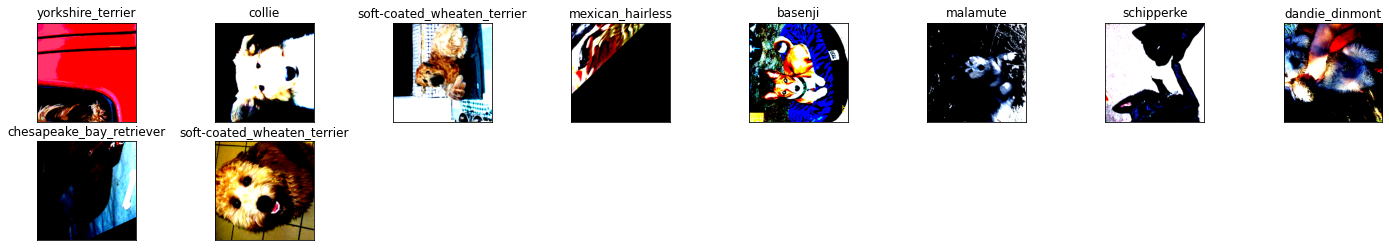

In [ ]:
idx2_class = {v: k for k, v in train_data.class_to_idx.items()}
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    image = np.transpose(images.cpu()[i])
    label = idx2_class[labels.cpu().tolist()[i]]
    ax = fig.add_subplot(2, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title(label)

In [ ]:
# สร้าง pretrained model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# เปลี่ยนพารามิเตอร์ใน fc ให้สำหรับทำนายพันธุ์หมาแทน, เช็คก่อนเสมอว่าโมเดลหน้าตาเป็นอย่างไร
model.fc = nn.Linear(in_features=512, out_features=len(train_data.classes))

In [ ]:
# สร้าง loss, optimizer
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3)

In [ ]:
# เช็คว่ามี GPU ที่สามารถใช้ได้มั้ย ถ้าใช้ได้นำโมเดลเข้าไปอยู่ใน GPU
gpu = torch.cuda.is_available()
print(gpu)
if gpu:
   model.cuda()

True


In [ ]:
n_epochs = 2
for epoch in range(n_epochs):
    # ช่วง train
    model.train()
    train_loss, val_loss = 0, 0
    for images, labels in tqdm(train_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        pred = model(images) # คำนวณหา output (pred) จาก โมเดลที่มีอยู่
        loss = cross_entropy(pred, labels)
        loss.backward() # คำนวณ gradient จาก loss ที่ได้
        optimizer.step() # อัพเดทพารามิเตอร์ของโมเดล
        train_loss += loss.item() * images.size(0)

    # ช่วง validate
    model.eval() # เซ็ตเป็น evaluation mode
    for images, labels in tqdm(val_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        pred = model(images)
        loss = cross_entropy(pred, labels)
        val_loss += loss.item() * images.size(0)
    print("Training loss = {}, Validation loss = {}".format(train_loss / n_train, val_loss / n_val))

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Training loss = 4.747204721622716, Validation loss = 4.5463247280540555


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Training loss = 4.44227278394397, Validation loss = 4.23115273198172


In [ ]:
# คำนวณหา classification report สำหรับ validation set
y_pred, y_true = [], []
model.eval() # เซ็ตเป็น evaluation mode
for images, labels in tqdm(val_loader):
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)
print(classification_report(y_true, y_pred))

  0%|          | 0/64 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.44      0.29      0.35        14
           1       0.08      0.85      0.15        13
           2       0.42      0.29      0.34        17
           3       0.12      0.19      0.14        16
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        18
           6       0.07      0.04      0.05        24
           7       0.06      0.20      0.09        20
           8       0.18      0.11      0.14        18
           9       0.19      0.30      0.23        20
          10       0.20      0.17      0.18        12
          11       0.20      0.26      0.23        27
          12       0.36      0.29      0.32        17
          13       0.14      0.29      0.19        17
          14       0.00      0.00      0.00        17
          15       0.08      0.07      0.07        15
          16       0.09      0.09      0.09        11
          17       0.25    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Accuracy on validation set = {}".format(
    accuracy_score(y_true, y_pred))
)

Accuracy on validation set = 0.1310513447432763


In [ ]:
print("Precision Recall F1-Score",
      precision_recall_fscore_support(y_true, y_pred, average="micro"))

Precision Recall F1-Score (0.1310513447432763, 0.1310513447432763, 0.1310513447432763, None)


##ทดลอง Forward pass

เราสามารถลองดูได้ว่า forward pass ของเราทำงานได้ปกติมั้ย

In [ ]:
x, y = next(iter(train_loader))
backbone = models.resnet34(pretrained=True)
backbone.fc = torch.nn.Linear(backbone.fc.in_features, n_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
y_hat = backbone(x)

In [ ]:
y_hat.shape, y.shape # batch size, number of classes

(torch.Size([32, 120]), torch.Size([32]))

In [ ]:
entropy_loss = nn.CrossEntropyLoss()
entropy_loss(y_hat, y)

tensor(4.9863, grad_fn=<NllLossBackward0>)

##Image classification ด้วย Pytorch Lightning

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.TrivialAugmentWide(),
    T.RandomResizedCrop((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),)
])

In [ ]:
train_data = datasets.ImageFolder("data/dogdata/train/", transform=train_transform)
val_data = datasets.ImageFolder("data/dogdata/validation/", transform=val_transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
classes = train_data.classes
n_classes = len(classes)

In [ ]:
class DogResNet(pl.LightningModule):
    def __init__(self, n_classes=120):
        super(DogResNet, self).__init__()
        
        # จำนวนของพันธุ์น้องหมา (120)
        self.n_classes = n_classes

        # ใช้สถาปัตยกรรม resnet34; เปลี่ยน layer สุดท้าย
        self.backbone = models.resnet34(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False
        # เปลี่ยน fc layer เป็น output ขนาด 120
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, n_classes)
        
        self.entropy_loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy()

    def forward(self, x):
        preds = self.backbone(x)
        return pred

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.backbone(x)
        loss = self.entropy_loss(logits, y)
        y_pred = torch.argmax(logits, dim=1)
        self.log("train_loss", loss)
        self.log("train_acc", self.accuracy(y_pred, y))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.backbone(x)
        loss = self.entropy_loss(logits, y)
        y_pred = torch.argmax(logits, dim=1)
        self.log("val_loss", loss)
        self.log("val_acc", self.accuracy(y_pred, y))
        return loss
        
    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return {
            "optimizer": self.optimizer,
            "monitor": "val_loss",
        }

In [ ]:
model = DogResNet(n_classes=n_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
checkpoint_callback = ModelCheckpoint(
   dirpath="./checkpoints/dogbreed/",
   filename="resnet18--{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}",
   save_top_k=1,
   verbose=True,
   monitor="val_loss",
   mode="min",
)

In [ ]:
trainer = pl.Trainer(max_epochs=10, gpus=1, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | backbone     | ResNet           | 21.3 M
1 | entropy_loss | CrossEntropyLoss | 0     
2 | accuracy     | Accuracy         | 0     
--------------------------------------------------
61.6 K    Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.385    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 256: 'val_loss' reached 1.48449 (best 1.48449), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=00-val_acc=0.65-val_loss=1.48.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 512: 'val_loss' reached 1.01182 (best 1.01182), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=01-val_acc=0.73-val_loss=1.01.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 768: 'val_loss' reached 0.88400 (best 0.88400), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=02-val_acc=0.74-val_loss=0.88.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 1024: 'val_loss' reached 0.82849 (best 0.82849), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=03-val_acc=0.75-val_loss=0.83.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1280: 'val_loss' reached 0.75005 (best 0.75005), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=04-val_acc=0.78-val_loss=0.75.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1536: 'val_loss' reached 0.73559 (best 0.73559), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=05-val_acc=0.78-val_loss=0.74.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1792: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 2048: 'val_loss' reached 0.70427 (best 0.70427), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=07-val_acc=0.78-val_loss=0.70.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 2304: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2560: 'val_loss' reached 0.69739 (best 0.69739), saving model to '/content/checkpoints/dogbreed/resnet18--epoch=09-val_acc=0.79-val_loss=0.70.ckpt' as top 1
